**Import Library yang Diperlukan:**

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

**Membaca Dataset:**

In [8]:
# Membaca dataset dari file Excel
df = pd.read_excel('Online Retail.xlsx', engine='openpyxl')

# Menampilkan beberapa baris pertama
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


**Data Preparation:**

Menghapus data yang tidak relevan dan menangani missing values:

In [9]:
df.dropna(subset=['CustomerID'], inplace=True)
df = df[df['Quantity'] > 0]  # Menghapus transaksi dengan quantity <= 0

Menghitung RFM:

In [11]:
# Menghitung tanggal terakhir
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Menghitung RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'UnitPrice': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'UnitPrice': 'Monetary'
})

rfm['Monetary'] = rfm['Monetary'].round(2)

**Feature Scaling:**

Standarisasi data untuk K-Means:

In [12]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

**Clustering dengan K-Means:**

Menentukan jumlah cluster menggunakan metode elbow:

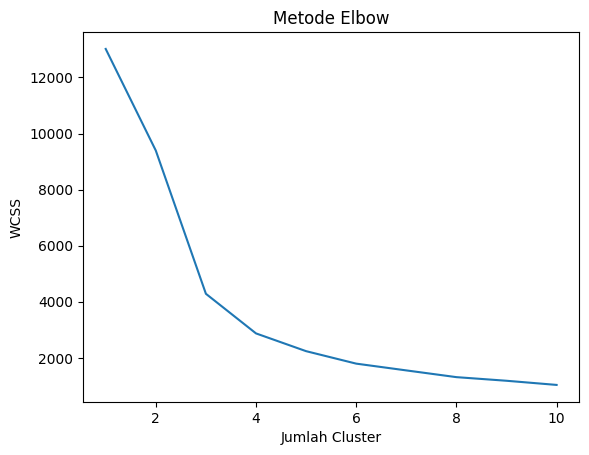

In [13]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Metode Elbow')
plt.xlabel('Jumlah Cluster')
plt.ylabel('WCSS')
plt.show()

Menjalankan K-Means dengan jumlah cluster yang ditentukan:

In [14]:
optimal_k = 4  # Ganti dengan nilai optimal dari metode elbow
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

**Clustering dengan DBSCAN:**

Menjalankan DBSCAN:

In [15]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
rfm['DBSCAN_Cluster'] = dbscan.fit_predict(rfm_scaled)

**Visualisasi Hasil Clustering:**

Visualisasi K-Means:

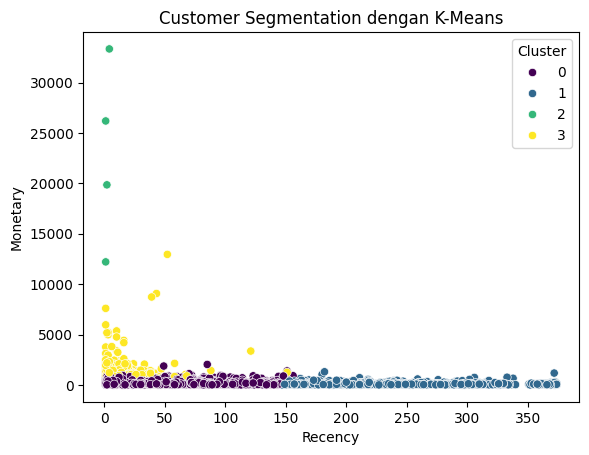

In [16]:
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('Customer Segmentation dengan K-Means')
plt.show()

Visualisasi DBSCAN:

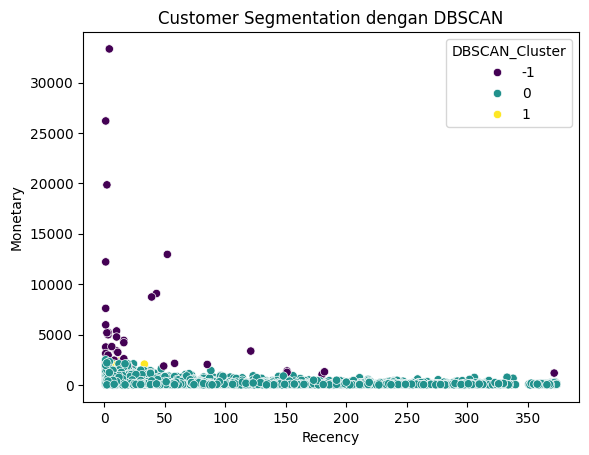

In [17]:
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='DBSCAN_Cluster', palette='viridis')
plt.title('Customer Segmentation dengan DBSCAN')
plt.show()

**Hasil dan Interpretasi**

In [18]:
cluster_analysis = rfm.groupby('Cluster').mean()
print(cluster_analysis)

            Recency    Frequency      Monetary  DBSCAN_Cluster
Cluster                                                       
0         43.903110    74.193781    221.347607       -0.000982
1        249.465028    27.635161     96.527070       -0.002836
2          2.000000  5807.750000  22893.065000       -1.000000
3         15.184685   535.103604   1667.053018       -0.085586
